In [8]:
!pip install pandas seaborn scikit-learn matplotlib --quiet


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# -----------------------------
# 1. Load & Inspect Data
# -----------------------------
url = 'https://raw.githubusercontent.com/EvansKizito/Datathon/refs/heads/main/claims_company_style_with_reported_year.csv'
df = pd.read_csv(url)
df.head()

,policy_id,line_of_business,exposure_premium,accident_year,development_year,incremental_paid,cumulative_paid,incremental_incurred,cumulative_incurred,reported_year
0,P0001,Health,12828.63,2005,1,5162.07,5162.07,3485.56,3485.56,2005
1,P0001,Health,12828.63,2005,2,22425.50,27587.57,8571.92,12057.47,2006
2,P0001,Health,12828.63,2005,3,1211.47,28799.05,6266.80,18324.28,2007
3,P0001,Health,12828.63,2005,4,3146.17,31945.22,9988.67,28312.95,2008
4,P0001,Health,12828.63,2005,5,2871.04,34816.26,5075.54,33388.48,2009


In [10]:
# -----------------------------
# 2. Aggregate into Loss Triangles
# -----------------------------
# Cumulative Paid triangle (sum across all policies)
tri_paid = df.pivot_table(
    index='accident_year',
    columns='development_year',
    values='cumulative_paid',
    aggfunc='sum'
).sort_index(axis=1)

# Cumulative Incurred triangle
tri_incur = df.pivot_table(
    index='accident_year',
    columns='development_year',
    values='cumulative_incurred',
    aggfunc='sum'
).sort_index(axis=1)

years = tri_paid.index.values
devs  = tri_paid.columns.values
print("Paid triangle shape:", tri_paid.shape)

Paid triangle shape: (16, 10)


In [11]:
# -----------------------------
# 3. Chain Ladder Implementation
# -----------------------------
def chain_ladder(triangle):
    """
    Compute Chain-Ladder ultimate reserves by:
    - Estimating development factors
    - Projecting ultimate for each accident year
    """
    n_ay, n_dy = triangle.shape
    # estimate link ratios (f_k = sum(C_{i,k+1}) / sum(C_{i,k}))
    factors = (
        np.nansum(triangle[:,1:], axis=0) /
        np.nansum(triangle[:,:-1], axis=0)
    )
    ultimates = np.zeros(n_ay)
    for i in range(n_ay):
        last_obs = np.where(~np.isnan(triangle[i]))[0][-1]
        cum = triangle[i, last_obs]
        # apply all future factors
        if last_obs < len(factors):
            ult = cum * np.prod(factors[last_obs:])
        else:
            ult = cum
        ultimates[i] = ult
    return ultimates, factors

# run on paid
triangle_paid = tri_paid.values
ult_cl, f_cl = chain_ladder(triangle_paid)

In [12]:
# -----------------------------
# 4. Bornhuetter–Ferguson Implementation
# -----------------------------
def bornhuetter_ferguson(triangle, expected_loss_ratio):
    """
    BF: R_i = ER_i * Exposure_i + (1 - beta_i) * (C_{i,n})
    where beta_i = sum of dev factors from k=0 to final,
    and ER_i = expected ultimate (we use E[L] = ELR * exposure).
    """
    # here we aggregate exposure per accident year
    exp_by_ay = df.groupby('accident_year')['exposure_premium'].sum().reindex(years).values
    # Development to tail factor
    n_ay, n_dy = triangle.shape
    ultimates = np.zeros(n_ay)
    for i in range(n_ay):
        last_obs = np.where(~np.isnan(triangle[i]))[0][-1]
        cdf = np.prod(f_cl[last_obs:]) if last_obs < len(f_cl) else 1.0
        beta = 1 - 1 / cdf
        reported = triangle[i, last_obs]
        ultimates[i] = reported + beta * expected_loss_ratio * exp_by_ay[i]
    return ultimates


In [13]:
total_exposure = df['exposure_premium'].sum()
avg_ult = triangle_paid[:, -1].sum() / total_exposure
ult_bf = bornhuetter_ferguson(triangle_paid, avg_ult)


In [14]:
# -----------------------------
# 5. Anomaly Detection (Isolation Forest)
# -----------------------------
X = df[['incremental_paid', 'incremental_incurred']].values
iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly'] = iso.fit_predict(X)   # -1 = anomaly, +1 = normal

# rebuild paid triangle without anomalies
clean = df[df['anomaly'] == 1]
tri_paid_clean = clean.pivot_table(
    index='accident_year', columns='development_year',
    values='cumulative_paid', aggfunc='sum'
).values

ult_cl_clean, _ = chain_ladder(tri_paid_clean)
ult_bf_clean = bornhuetter_ferguson(tri_paid_clean, avg_ult)

In [15]:
# -----------------------------
# 6. Evaluation Metrics
# -----------------------------
actual = triangle_paid[:, -1]

def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def mare(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))

results = pd.DataFrame({
    'Method': [
        'CL (raw)', 'CL (clean)',
        'BF (raw)', 'BF (clean)'
    ],
    'MAPE (%)': [
        mape(actual, ult_cl),
        mape(actual, ult_cl_clean),
        mape(actual, ult_bf),
        mape(actual, ult_bf_clean),
    ],
    'RMSE': [
        rmse(actual, ult_cl),
        rmse(actual, ult_cl_clean),
        rmse(actual, ult_bf),
        rmse(actual, ult_bf_clean),
    ],
    'MARE': [
        mare(actual, ult_cl),
        mare(actual, ult_cl_clean),
        mare(actual, ult_bf),
        mare(actual, ult_bf_clean),
    ]
})
print(results)


       Method  MAPE (%)           RMSE          MARE
0    CL (raw)   0.00000       0.000000       0.00000
1  CL (clean)   3.37667  706158.407637  629206.09875
2    BF (raw)   0.00000       0.000000       0.00000
3  BF (clean)   3.37667  706158.407637  629206.09875


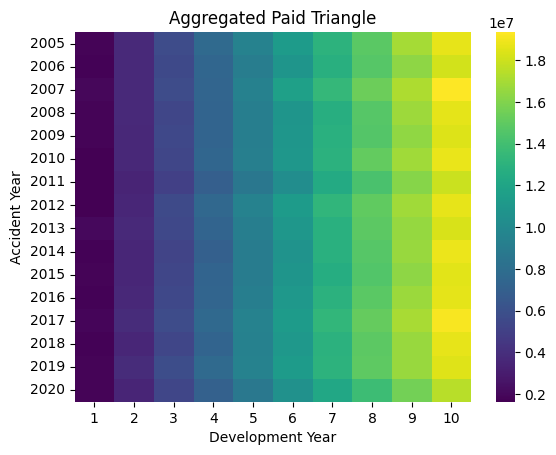

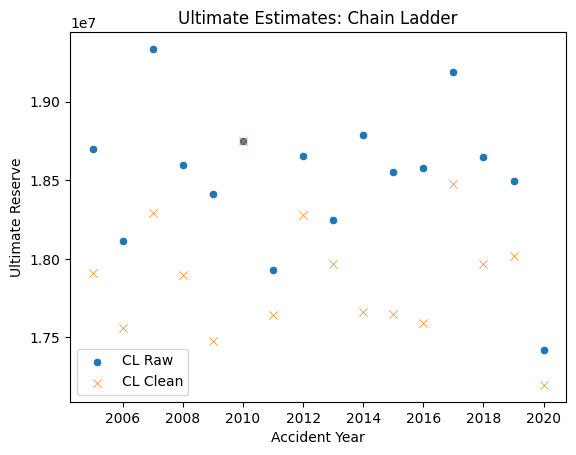

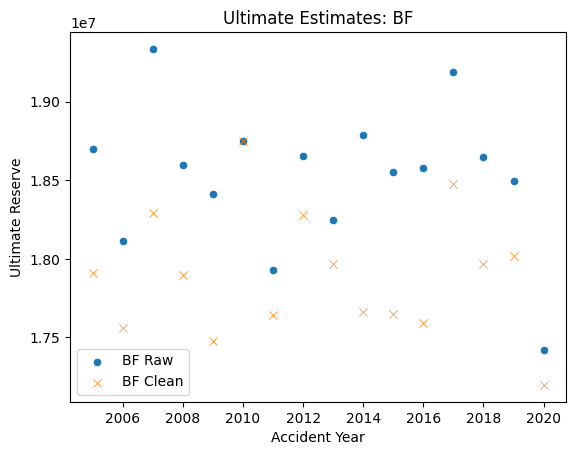

In [16]:
# -----------------------------
# 7. Visualizations
# -----------------------------
import seaborn as sns
sns.heatmap(tri_paid, cmap='viridis', xticklabels=devs, yticklabels=years)
plt.title('Aggregated Paid Triangle')
plt.xlabel('Development Year')
plt.ylabel('Accident Year')
plt.show()

sns.scatterplot(
    x=years, y=ult_cl, label='CL Raw', marker='o'
)
sns.scatterplot(
    x=years, y=ult_cl_clean, label='CL Clean', marker='x'
)
plt.title('Ultimate Estimates: Chain Ladder')
plt.xlabel('Accident Year')
plt.ylabel('Ultimate Reserve')
plt.legend()
plt.show()

sns.scatterplot(x=years, y=ult_bf, label='BF Raw', marker='o')
sns.scatterplot(x=years, y=ult_bf_clean, label='BF Clean', marker='x')
plt.title('Ultimate Estimates: BF')
plt.xlabel('Accident Year')
plt.ylabel('Ultimate Reserve')
plt.legend()
plt.show()
